# Online DA: 
## CESM LME prior/LIM, HadCRUT5 observations

In [1]:
import sys
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pickle 

In [2]:
sys.path.append("../")
import Online_DA_utils as oda

In [3]:
import importlib
importlib.reload(oda)

<module 'Online_DA_utils' from '../Online_DA_utils.py'>

### Load L: 

In [4]:
LIM = oda.load_L('cesm_lme_Amon')
# LIM = oda.load_L('cesm_lme_nh')
LIMd = LIM['LIMd']
LIMd.keys()

Loading: /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/master/LIMcast_cesm_lme_Amon_ntrain_850_1650_cesm_lme_Amon_validy_1651_1850_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20211202_sqrtWt.pkl


dict_keys(['vec', 'veci', 'val', 'lam_L', 'C_0', 'C_1', 'Gt', 'lam_L_adj', 'npos_eigenvalues', 'E3', 'W_all', 'standard_factor', 'E3_all', 'E_sic', 'var_dict', 'P_train', 'exp_setup', 'frac_neg_eigenvals'])

## Pseudo obs from CESM LME:  

In [5]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as kbstats
import LIM_plot_kb as plotkb
import LIM_building as limbuild

In [32]:
mo='all'
#mo=7

# forecast lead time in months that defines the LIM training
tau = 1

#lat_cutoff = 0.1
lat_cutoff_dict = {'tas':0.1,'psl':0.1,'zg':0.1,'tos':0.1,'sit':40,'sic':40}

# ntrain = 800
# nvalid = 200

# tscut = False     # time start cut 
# tecut = 355       # 800 training years LME
# tecut = 0
#tscut = 800
#tscut = 1001
tscut = 1
tecut = None
tecut = 156
# tscut = 1001
# tecut = 155
# tscut = 0

limvars = []

limvars_nosic = ['tas','psl','zg','tos','sit','sic']
nvars = len(limvars)

# train_dsource = 'cesm_lme'
# valid_dsource = 'cesm_lme'
train_dsource = 'cesm_lme_Amon'
#valid_dsource = 'cesm_lme_Amon'
#train_dsource = 'cmip6_mpi_hist_regridlme_Amon'
valid_dsource = 'cmip6_mpi_hist_regridlme_Amon'


sic_separate = True
Insamp = False
dt=True
wt=True

In [33]:
fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names(valid_dsource)

In [34]:
var_dict = {}
X_var_all = {}
var = 'tas'

X_var, var_dict = limkb.load_data(var, var_dict, fdic_valid, remove_climo=True, 
                                  detrend=dt, verbose=True, cmip6=False, 
                                  tscut=tscut, tecut=tecut, lat_cutoff=lat_cutoff_dict[var])

if mo is 'all':
    print('Using month: '+str(mo))
    X_var_in = X_var
else: 
    print('Using month: '+str(mo))
    tsamp = X_var.shape[1]
    x_var = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))[:,:,mo:mo+2]
    X_var_in = np.reshape(x_var, (x_var.shape[0],x_var.shape[1]*x_var.shape[2]))

if var is 'sic':
    if np.nanmax(X_var)>1:
        print('Changing units of sic be a between 0 to 1')
        X_var_in = X_var_in/100

X_var_all[var] = X_var_in

Loading from tas
Loading from MPI-ESM1-2-LR_historical_r1i1p1f1_regridlme_185001-201412.nc
time dimension: 1851 - 2005
latitude cutoff detected: 0.1
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 10.60417628288269 seconds
-----------------------------------------------------
Using month: all


In [35]:
X_var.shape

(6912, 1860)

In [36]:
tas_lat = var_dict['tas']['lat']
tas_lon = var_dict['tas']['lon']

In [37]:
X_var_3d = np.reshape(X_var,(tas_lat.shape[0],tas_lon.shape[0],X_var.shape[1]))

### Load/use HadCRUT obs locations: 

In [38]:
HadCRUT_tas, HadCRUT_lat, HadCRUT_lon, HadCRUT_time = oda.load_HadCRUT5()

In [39]:
obsdir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/observations/'
had_file = 'Hadcrut_data_mask_CESMLME_grid.pkl'
#had_file = 'Hadcrut_data_on_CESMLME_grid_NH_fixed_network36.pkl'

had_mask_data = pickle.load(open(obsdir+had_file,"rb"))

In [40]:
# had_mask = had_mask_data['hadcrut_closest_CESM_gridpoint'][12:,:,:]
# had_mask_nh = had_mask_data['hadcrut_closest_CESM_gridpoint'][12:,-48:,:]
had_mask = had_mask_data['hadcrut_closest_CESM_gridpoint'][12:1872,:,:]
had_mask_nh = had_mask_data['hadcrut_closest_CESM_gridpoint'][12:1872,-48:,:]

# had_obs_fixed = had_mask_data['had_on_refgrid'][12:1872,:,:]
# had_mask_nh = np.where(np.isfinite(had_obs_fixed),1,0)

In [41]:
had_mask_nh.shape

(1860, 48, 144)

In [42]:
H_rshp = np.reshape(np.reshape(had_mask_nh,(1860,48*144)).T,(48,144,1860))
#H_rshp = np.reshape(np.reshape(had_mask_nh,(2051,48*144)).T,(48,144,2051))
H = np.where(H_rshp<1,np.nan,1)

In [43]:
obs = (H*X_var_3d)
obs_plot = obs[np.isfinite(obs[:,:,0]),0]

In [53]:
np.nansum(H[:,:,0])

259.0

In [45]:
tas_lat_2d = np.ones((48,144))*tas_lat[:,np.newaxis]
tas_lon_2d = np.ones((48,144))*tas_lon

In [46]:
obs_lat_hold = tas_lat_2d*H[:,:,0]
obs_lat = obs_lat_hold[np.isfinite(obs_lat_hold)]

obs_lon_hold = tas_lon_2d*H[:,:,0]
obs_lon = obs_lon_hold[np.isfinite(obs_lon_hold)]

In [47]:
obs_lon.shape, obs_lat.shape

((259,), (259,))

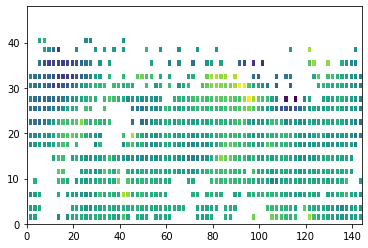

In [48]:
plt.pcolormesh((H*X_var_3d)[:,:,1000])

Text(0.5, 1.0, 'Pseudo observations')

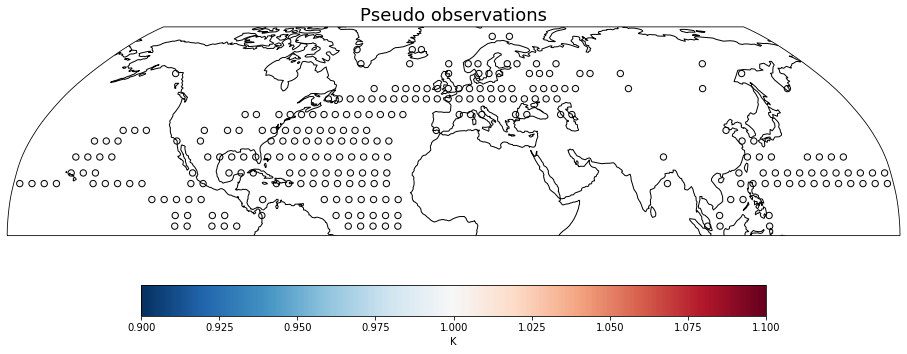

In [286]:
t = 0

fig = plt.figure(1, figsize=(16, 6))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()

lim = np.ceil(max(np.abs(obs.min()), np.abs(obs.max())))

cb = axs.scatter(obs_lon, obs_lat, s=40, c=H[(H[:,:,0]>0),t].flatten(),cmap='RdBu_r',
                 transform=ccrs.PlateCarree(), edgecolor='k')

plt.colorbar(cb, orientation='horizontal', shrink=0.7, label='K')
plt.title('Pseudo observations', fontsize=18)

Text(0.5, 1.0, 'Pseudo observations')

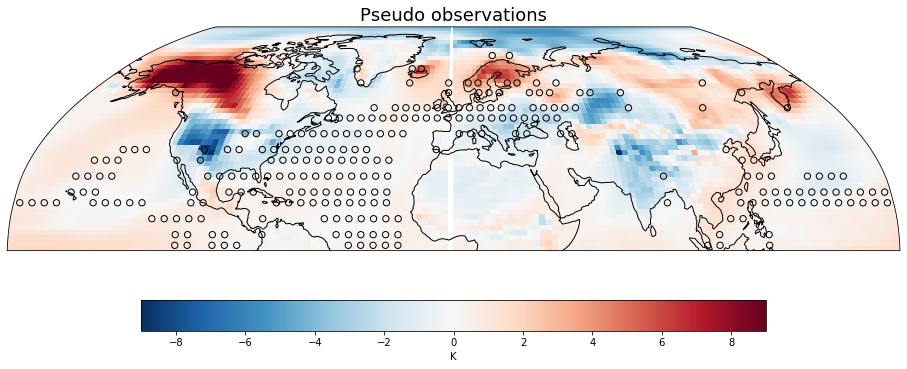

In [287]:
t = 0

fig = plt.figure(1, figsize=(16, 6))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()

lim = np.ceil(max(np.abs(obs_plot.min()), np.abs(obs_plot.max())))

#hadcrut_ds.tas_mean.isel(time=0).plot.pcolormesh('longitude','latitude',ax=axs,transform=ccrs.PlateCarree(),vmax=10)

# plt.scatter(x=lon,y=lat,s=H,transform=ccrs.PlateCarree())
axs.pcolormesh(tas_lon,tas_lat,X_var_3d[:,:,t],cmap='RdBu_r',
               transform=ccrs.PlateCarree(),vmin=-lim,vmax=lim,)

cb = axs.scatter(obs_lon, obs_lat, s=40, c=obs_plot,cmap='RdBu_r',
                 transform=ccrs.PlateCarree(),vmin=-lim,vmax=lim, edgecolor='k')

plt.colorbar(cb, orientation='horizontal', shrink=0.7, label='K')
plt.title('Pseudo observations', fontsize=18)

In [55]:
pseudo_observations = {}
pseudo_observations['observations'] = obs
pseudo_observations['obs_lat'] = obs_lat_2d
pseudo_observations['obs_lon'] = obs_lon_2d
pseudo_observations['H'] = H
pseudo_observations['X_var_3d'] = X_var_3d

obsdir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/observations/'
#save_filename = 'TAS_pseudo_obs_CESM_LME_1851_2005.pkl'
save_filename = 'TAS_pseudo_obs_'+valid_dsource+'_hadCRUT_locations_1851_2005.pkl'
#save_filename = 'TAS_pseudo_obs_'+valid_dsource+'_hadCRUT_locations_fixed_network36_1851_2005.pkl'

print('saving in: '+obsdir+save_filename)
pickle.dump(pseudo_observations, open(obsdir+save_filename, "wb" ))

NameError: name 'obs_lat_2d' is not defined

### Use randomly spaced pseudo obs: 

In [230]:
dlat = 10
dlon = 8

# dlat = 5
# dlon = 4

In [231]:
all_obs = X_var_3d[0::dlat,0::dlon,:]
obs = all_obs[:-1,:,:]
obs_lat = tas_lat[0::dlat]
obs_lon = tas_lon[0::dlon]

nlon = obs_lon.shape[0]
nlat = obs_lat.shape[0]

obs_lat_2d = (np.ones((nlat-1,nlon))*obs_lat[:-1,np.newaxis]).flatten()
obs_lon_2d = (np.ones((nlat-1,nlon))*obs_lon).flatten()
# obs_lat_2d = (np.ones((9,36))*obs_lat[:-1,np.newaxis]).flatten()
# obs_lon_2d = (np.ones((9,36))*obs_lon).flatten()

In [232]:
obs_lon[:-1] - obs_lon[1:]

array([-20., -20., -20., -20., -20., -20., -20., -20., -20., -20., -20.,
       -20., -20., -20., -20., -20., -20.])

In [233]:
obs_lat[:-1] - obs_lat[1:]

array([-18.94736842, -18.94736842, -18.94736842, -18.94736842])

In [238]:
H = np.zeros_like((X_var_3d))

H[0:40:dlat,0::dlon,:] = H[0:40:dlat,0::dlon,:]+1

In [239]:
H.shape, (H[:,:,0]>0).sum()

((48, 144, 1860), 72)

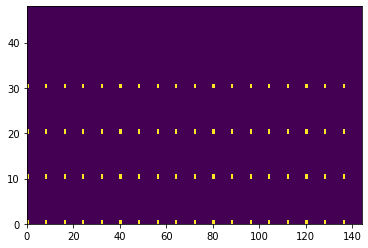

In [240]:
plt.pcolormesh(H[:,:,0])

In [241]:
obs_lon_2d.shape, obs_lat_2d.shape, H[(H[:,:,0]>0),0].shape

((72,), (72,), (72,))

Text(0.5, 1.0, 'Pseudo observations')

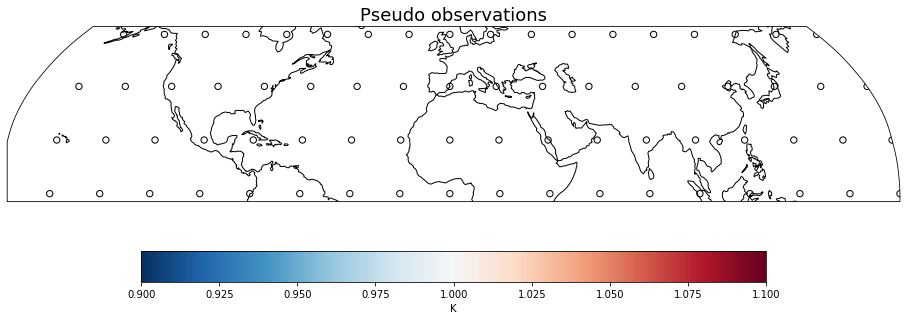

In [242]:
t = 0

fig = plt.figure(1, figsize=(16, 6))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()

lim = np.ceil(max(np.abs(obs.min()), np.abs(obs.max())))

cb = axs.scatter(obs_lon_2d, obs_lat_2d, s=40, c=H[(H[:,:,0]>0),t].flatten(),cmap='RdBu_r',
                 transform=ccrs.PlateCarree(), edgecolor='k')

plt.colorbar(cb, orientation='horizontal', shrink=0.7, label='K')
plt.title('Pseudo observations', fontsize=18)

Text(0.5, 1.0, 'Pseudo observations')

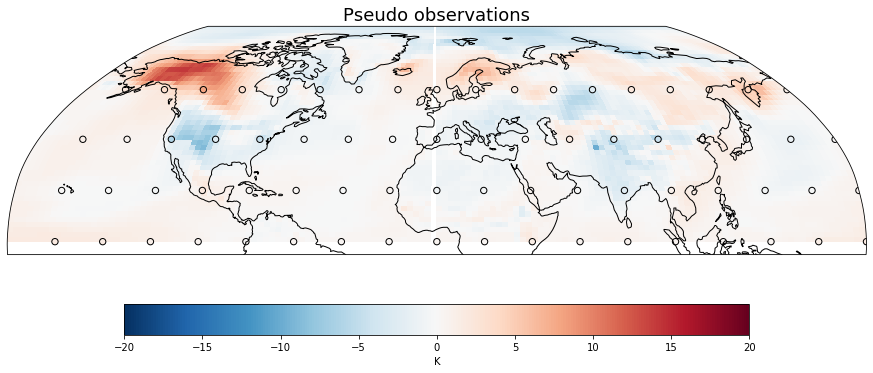

In [243]:
t = 0

fig = plt.figure(1, figsize=(16, 6))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()

lim = np.ceil(max(np.abs(obs.min()), np.abs(obs.max())))

#hadcrut_ds.tas_mean.isel(time=0).plot.pcolormesh('longitude','latitude',ax=axs,transform=ccrs.PlateCarree(),vmax=10)

# plt.scatter(x=lon,y=lat,s=H,transform=ccrs.PlateCarree())
axs.pcolormesh(tas_lon,tas_lat,X_var_3d[:,:,t],cmap='RdBu_r',
               transform=ccrs.PlateCarree(),vmin=-lim,vmax=lim,)

cb = axs.scatter(obs_lon_2d, obs_lat_2d, s=40, c=obs[:,:,t].flatten(),cmap='RdBu_r',
                 transform=ccrs.PlateCarree(),vmin=-lim,vmax=lim, edgecolor='k')

plt.colorbar(cb, orientation='horizontal', shrink=0.7, label='K')
plt.title('Pseudo observations', fontsize=18)

In [244]:
obs.shape, 9*36

((4, 18, 1860), 324)

In [245]:
pseudo_observations = {}
pseudo_observations['observations'] = obs
pseudo_observations['obs_lat'] = obs_lat_2d
pseudo_observations['obs_lon'] = obs_lon_2d
pseudo_observations['H'] = H
pseudo_observations['X_var_3d'] = X_var_3d

obsdir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/observations/'
#save_filename = 'TAS_pseudo_obs_CESM_LME_1851_2005.pkl'
save_filename = 'TAS_pseudo_obs_'+valid_dsource+'_dlat19_dlon20_1851_2005.pkl'

print('saving in: '+obsdir+save_filename)
pickle.dump(pseudo_observations, open(obsdir+save_filename, "wb" ))

saving in: /home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/observations/TAS_pseudo_obs_cesm_lme_Amon_dlat19_dlon20_1851_2005.pkl


## Prior from CESM LME: 

In [13]:
mo='all'
#mo=7

# forecast lead time in months that defines the LIM training
tau = 1

#lat_cutoff = 0.1
lat_cutoff_dict = {'tas':0.1,'psl':0.1,'zg':0.1,'tos':0.1,'sit':40,'sic':40}

# ntrain = 800
# nvalid = 200

# tscut = False     # time start cut 
# tecut = 355       # 800 training years LME
# tecut = 0
# tscut = 800
# tecut = 1001
# tscut = 801
# tecut = None
# tscut = 1001
tecut = None
tscut = 0
# tecut = 155
# tscut = 0

limvars = ['tas','psl','zg','tos','sit','sic']
nvars = len(limvars)

# train_dsource = 'cesm_lme_Amon'
# valid_dsource = 'cesm_lme_Amon'
train_dsource = 'multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon'
valid_dsource = 'multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon'
# train_dsource = 'cmip6_mpi_hist_regridlme_Amon'
# valid_dsource = 'cmip6_mpi_hist_regridlme_Amon'


sic_separate = True
Insamp = False
dt=True
wt=True

In [14]:
fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names(valid_dsource)

In [15]:
var_dict = {}
X_var_all = {}
Ptrunc_valid = {}
var_dict_valid = {}

for var in limvars: 
    X_var, var_dict = limkb.load_data(var, var_dict, fdic_valid, remove_climo=True, 
                                      detrend=dt, verbose=True, cmip6=False, 
                                      tscut=tscut, tecut=tecut, lat_cutoff=lat_cutoff_dict[var])

    if mo is 'all':
        print('Using month: '+str(mo))
        X_var_in = X_var
    else: 
        print('Using month: '+str(mo))
        tsamp = X_var.shape[1]
        x_var = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))[:,:,mo:mo+2]
        X_var_in = np.reshape(x_var, (x_var.shape[0],x_var.shape[1]*x_var.shape[2]))

    if var is 'sic':
        if np.nanmax(X_var)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var_in = X_var_in/100

    Ptrunc_valid[var] = limkb.step1_projection_validation_var(X_var_in, LIMd['E3'][var], 
                                                              LIMd['standard_factor'][var],
                                                              LIMd['W_all'][var], Weights=LIMd['exp_setup']['Weight'])

Loading from tas
Loading from ch_historical_detrended_latcut0.1_regridlme_185001-247312.nc
latitude cutoff detected: 0.1
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 7.582484245300293 seconds
-----------------------------------------------------
Using month: all
Loading from psl
Loading from ch_historical_detrended_latcut0.1_regridlme_185001-247312.nc
latitude cutoff detected: 0.1
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
comp

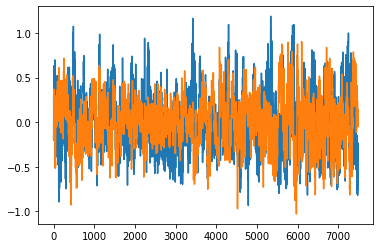

In [16]:
plt.plot(Ptrunc_valid['sic'][0,:])
plt.plot(Ptrunc_valid['sit'][0,:])
# plt.plot(Ptrunc_valid['tas'][:,0])

In [17]:
var_dict = limbuild.get_var_indices(LIMd['exp_setup']['limvars'], var_dict)
ndof_all_valid = limkb.count_ndof_all(LIMd['exp_setup']['limvars'], LIMd['E3'], 
                                      sic_separate=LIMd['exp_setup']['sic_separate'])

working on tas
working on psl
working on zg
working on tos
working on sit
working on sic


In [18]:
[Ptrunc_all_valid, E3_all_valid,
 Ptrunc_sic_valid, E_sic_valid] = limkb.stack_variable_eofs(LIMd['exp_setup']['limvars'], ndof_all_valid, 
                                                            LIMd['exp_setup']['ntrunc'],Ptrunc_valid, 
                                                            LIMd['E3'], var_dict, 
                                                            sic_separate=LIMd['exp_setup']['sic_separate'])

0, tas
1, psl
2, zg
3, tos
4, sit


In [19]:
P_train_valid = np.concatenate((Ptrunc_all_valid, Ptrunc_sic_valid),axis=0) 

In [20]:
Xb_initial = P_train_valid

In [21]:
valid_dsource

'multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon'

In [22]:
var_dict['tas']['time']

array([cftime._cftime.DatetimeNoLeap(1850, 1, 15, 0, 0, 0, 0, 4, 15),
       cftime._cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0, 0, 46),
       cftime._cftime.DatetimeNoLeap(1850, 3, 15, 0, 0, 0, 0, 0, 74), ...,
       cftime._cftime.DatetimeNoLeap(2473, 10, 15, 0, 0, 0, 0, 4, 288),
       cftime._cftime.DatetimeNoLeap(2473, 11, 15, 0, 0, 0, 0, 0, 319),
       cftime._cftime.DatetimeNoLeap(2473, 12, 15, 0, 0, 0, 0, 2, 349)],
      dtype=object)

In [19]:
Xb_initial.shape[1]/12
1850+155

2005

In [23]:
initial_prior = {}
initial_prior['Xb_initial'] = Xb_initial

priordir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/priors/'
#save_filename = 'Xb_initial_'+valid_dsource+'_300ndof_1651_1850.pkl'
# save_filename = 'Xb_initial_'+valid_dsource+'_300ndof_1851_2005.pkl'
#save_filename = 'Xb_initial_'+valid_dsource+'_300ndof_850_1650.pkl'
save_filename = 'Xb_initial_'+valid_dsource+'_300ndof_1850_2473.pkl'

print('saving in: '+priordir + save_filename)
pickle.dump(initial_prior, open(priordir + save_filename, "wb" ))

saving in: /home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/priors/Xb_initial_multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon_300ndof_1850_2473.pkl


## Prior initial time: 

In [ ]:
mo='all'
#mo=7

# forecast lead time in months that defines the LIM training
tau = 1

#lat_cutoff = 0.1
lat_cutoff_dict = {'tas':0.1,'psl':0.1,'zg':0.1,'tos':0.1,'sit':40,'sic':40}

# ntrain = 800
# nvalid = 200

# tscut = False     # time start cut 
# tecut = 355       # 800 training years LME
# tecut = 0
# tscut = 800
# tecut = None
# tscut = 1001
tecut = None
tscut = 0

limvars = ['tas','psl','zg','tos','sit','sic']
nvars = len(limvars)

# train_dsource = 'cesm_lme'
# valid_dsource = 'cesm_lme'
train_dsource = 'cmip6_mpi_hist_regridlme'
valid_dsource = 'cmip6_mpi_hist_regridlme'


sic_separate = True
Insamp = False
dt=True
wt=True